In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from sklearn.feature_selection import mutual_info_regression
import matplotlib.patches as patches
from sklearn.model_selection import GridSearchCV

%matplotlib inline

In [2]:
## Lets load the data

full_df = pd.read_pickle("full_df_2021_CO2.pkl")
pd.set_option('display.max_columns', None)

## This the data cleaning. Keeping only the relevant features and removing the less than equal to zero target values

df1= full_df.drop(full_df.columns[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,17,18,19,20,21,23]], axis=1)

j=[]
for i in range(4,72):
    j.append(i)
df2 = df1.drop(df1.columns[j], axis=1)
df3 = df2.drop(df2.columns[[11,12,13,14,15,16,17,18]], axis=1)
df3.rename(columns={'pda': 'Average Pupil Diameter (mm)', 'pup_dis': 'Pupil Distance (mm)','pd_diff_abs': '|Difference in Pupil Diameter| (mm)', 'ECG.': 'ECG (V)','Resp.': 'Respiration Rate (brpm)','Temp.': 'Skin Temperature ($\mathrm{^o C})$','HR': 'Heart Rate (bpm)','CO2':'$\mathrm{CO_2}$ (ppm)','SpO2':'$\mathrm{SpO_2}$ (%)','GSR':'GSR ($\mathrm{\mu S}$)'}, inplace=True)

## Lets change some of variables to standard units

df3['$\mathrm{SpO_2}$ (%)']=df3['$\mathrm{SpO_2}$ (%)']*1000000 ## change the SpO2 to percentage

df3['GSR ($\mathrm{\mu S}$)']=df3['GSR ($\mathrm{\mu S}$)']*1000 ## convert kiloohms to ohms
df3['GSR ($\mathrm{\mu S}$)']=1/df3['GSR ($\mathrm{\mu S}$)']  ## convert ohms to siemans by taking the reciprocal
df3['GSR ($\mathrm{\mu S}$)']=df3['GSR ($\mathrm{\mu S}$)']*1000000 ## convert siemens to microsiemens

df3 = df3.drop(df3.columns[6], axis=1) ## drop the PPG as physical interpration was difficult. Also, it was used to measure SpO2 by the sensor

j=[]
for i in range(10,330):
    j.append(i)
df3 = df3.drop(df3.columns[j], axis=1)

df3 = df3.drop(df3.columns[[1,2,3,4]], axis=1)
df3


,$\mathrm{CO_2}$ (ppm),Respiration Rate (brpm),$\mathrm{SpO_2}$ (%),Heart Rate (bpm),GSR ($\mathrm{\mu S}$),Skin Temperature ($\mathrm{^o C})$
dateTime,,,,,,
2021-06-09 10:55:43.047,347.151,36.954880,99.0,72.0,0.085379,31.2500
2021-06-09 10:55:44.046,347.386,37.000731,99.0,72.0,0.085404,31.1875
2021-06-09 10:55:45.046,346.418,37.229978,100.0,72.0,0.085379,31.1250
2021-06-09 10:55:53.046,347.109,36.679782,99.0,72.0,0.085276,31.2500
2021-06-09 10:55:54.046,346.136,36.542233,98.0,73.0,0.085250,31.0625
...,...,...,...,...,...,...
2021-06-10 11:27:04.678,892.025,27.739085,97.0,124.0,0.092703,29.4375
2021-06-10 11:27:05.673,891.586,27.739085,97.0,124.0,0.093008,29.5000
2021-06-10 11:27:06.678,891.690,28.060032,98.0,124.0,0.092886,29.5625


In [3]:
## Lets create a Train-Test set and transform the data.

features=df3.drop('$\mathrm{CO_2}$ (ppm)',axis=1)
target=df3['$\mathrm{CO_2}$ (ppm)'].copy()

#from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(features, target, test_size=0.20)



In [4]:
## lets optimize the hyperparameters

param_grid=[{'n_estimators':[40,50,60], 'max_features':[2,4,5]}, 
                                             {'bootstrap':[False],'n_estimators':[90,110,120],'max_features':[3,5]},]
        

In [5]:
forest_reg=RandomForestRegressor()
grid_search=GridSearchCV(forest_reg,param_grid,cv=3,scoring="neg_mean_squared_error",return_train_score=True)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 5],
                          'n_estimators': [40, 50, 60]},
                         {'bootstrap': [False], 'max_features': [3, 5],
                          'n_estimators': [90, 110, 120]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [6]:
grid_search.best_estimator_

RandomForestRegressor(max_features=4, n_estimators=40)

In [7]:
## lets now select the model. This will be used later
final_model=grid_search.best_estimator_

In [8]:
final_model.fit(X_train,y_train)

train_prediction_RF=final_model.predict(X_train)
RF_mse=mean_squared_error(y_train,train_prediction_RF)
RF_rmse=np.sqrt(RF_mse)
RF_rmse_train=RF_rmse

print('The train RMSE for CO2 is:::', '%.2f' % RF_rmse)

The train RMSE for CO2 is::: 8.90


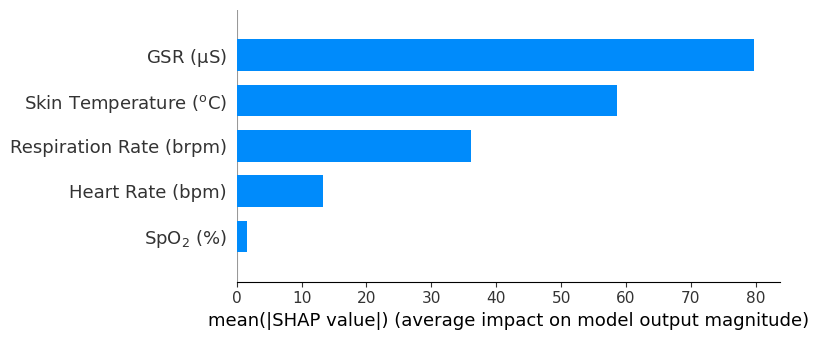

In [9]:
## Lets now use SHAP values for feature importance

import shap

shap_values = shap.TreeExplainer(final_model).shap_values(X_train)

shap.summary_plot(shap_values, X_train, plot_type="bar")



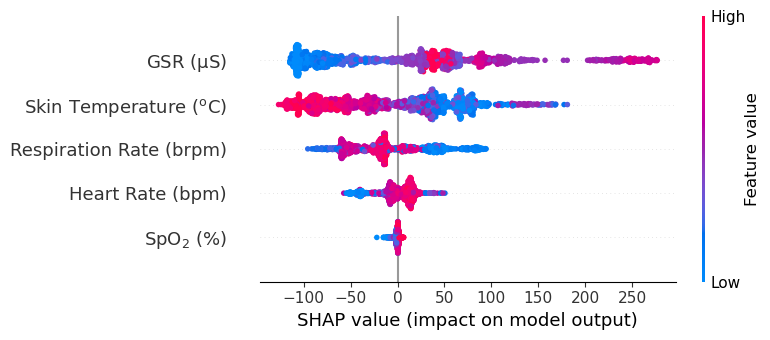

In [10]:
shap.summary_plot(shap_values, X_train)

Text(0.5, 1.0, "Pearson's Correlation Coefficient Plot")

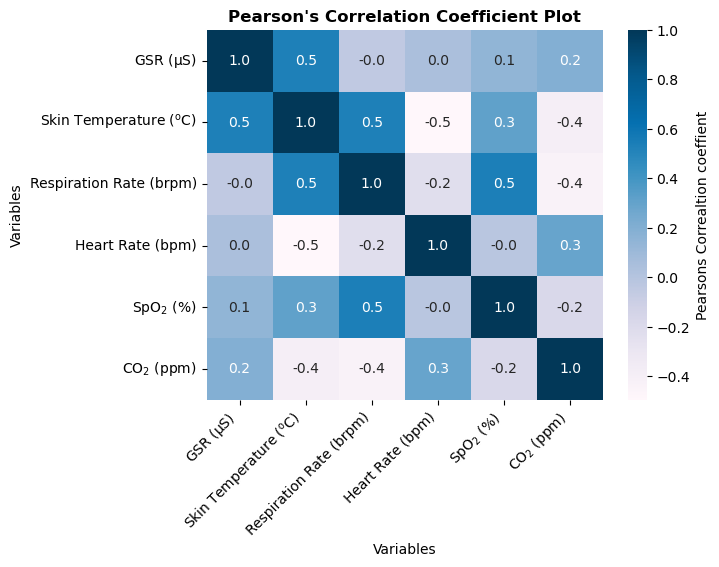

In [11]:
## lets get the top features as selected by SHAP values

shap_names=X_train.columns[np.argsort(np.abs(shap_values).mean(0))]  ## gives entire names in ascending order

## lets reverse the list of the names
shap_descending=[]
for i in reversed(shap_names):
    shap_descending.append(i)

## lets get the features as selected by SHAP values
    
names_rev_shap=[]
for i in range(0,5):
    names_rev_shap.append(shap_descending[i])
    
## lets plot the correlation plot

names_rev_shap.append('$\mathrm{CO_2}$ (ppm)') ## add the target CO2 for the correlation matrix
corr=df3[names_rev_shap].corr()
corr

import seaborn as sns


ax=sns.heatmap(corr,cmap="PuBu",annot=True,fmt=".1f",cbar_kws={'label': 'Pearsons Correaltion coeffient'})

plt.xticks(rotation=45,horizontalalignment='right')

ax.set(xlabel="Variables",ylabel="Variables")

plt.title("Pearson's Correlation Coefficient Plot",fontweight='bold')

Text(0.5, 1.0, 'Mutual Information Plot')

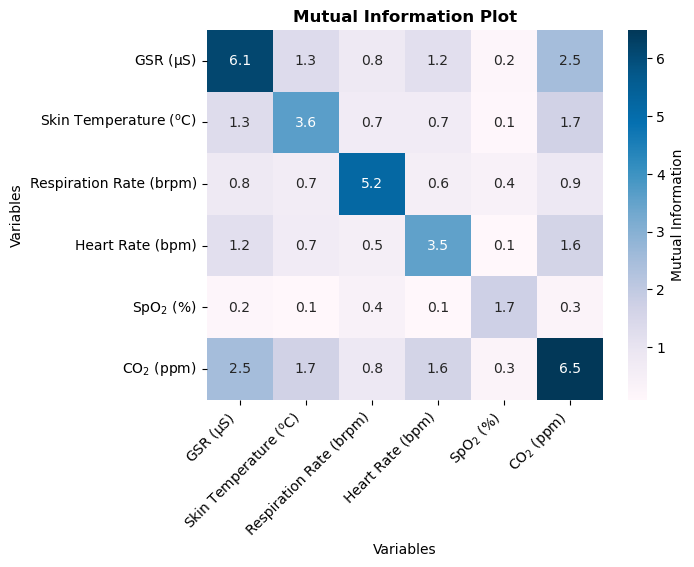

In [12]:
## Now lets plot the mutual information

#from sklearn.feature_selection import mutual_info_regression

## Lets calucalute the mutual information 

mf_mat=[]
for i in range(0,6):
    for j in range(0,6):
        dd=df3[names_rev_shap[i]]  ## extracting the labels
        mm=df3[names_rev_shap[j]]  ## extracting the labels

        kk=dd.to_numpy().reshape((-1,1)) ## reshape the array to (2317,1)
        
        vv=mm.to_numpy().reshape((-1,1))
        pp=vv.reshape(2317,)             ## reshape the array to (2317,) as required by the mutual_info_regression function
        
        
        mi=mutual_info_regression(kk,pp)
        mf_mat.append(mi)

mf_mat_arr=np.asarray(mf_mat)  ## transform the elements from a list to array

# reshape array 

reshaped_array = mf_mat_arr.reshape(6, 6).T 

mf_df=pd.DataFrame(reshaped_array,columns=[names_rev_shap],index=[names_rev_shap]) ## convert into a pandas DataFrame
mf_df

ax=sns.heatmap(mf_df,cmap="PuBu",annot=True,fmt='.1f',cbar_kws={'label':'Mutual Information'}) ## Now lets plot the mutual information heatmap

plt.xticks(rotation=45,horizontalalignment='right')

ax.set(title="Mutual Information Plot",xlabel="Variables",ylabel="Variables")

plt.title("Mutual Information Plot",fontweight='bold')

In [13]:
## The test prediction

test_prediction_RF=final_model.predict(X_test)

RF_mse=mean_squared_error(y_test,test_prediction_RF)
RF_rmse=np.sqrt(RF_mse)
RF_rmse_test=RF_rmse

print('The test RMSE for CO2 is:::', '%.2f' % RF_rmse)



The test RMSE for CO2 is::: 16.64


In [14]:
### The correlation values

#from scipy.stats import pearsonr

## The train correlation
train_r_sq=(pearsonr(y_train,train_prediction_RF)[0])**2
correlation_train=int(train_r_sq*100)/100 ## display only two digits without rounding
print(correlation_train)

## The test correlation
test_r_sq=(pearsonr(y_test,test_prediction_RF)[0])**2
correlation_test=int(test_r_sq*100)/100 ## display only two digits without rounding
print(correlation_test)

0.99
0.98


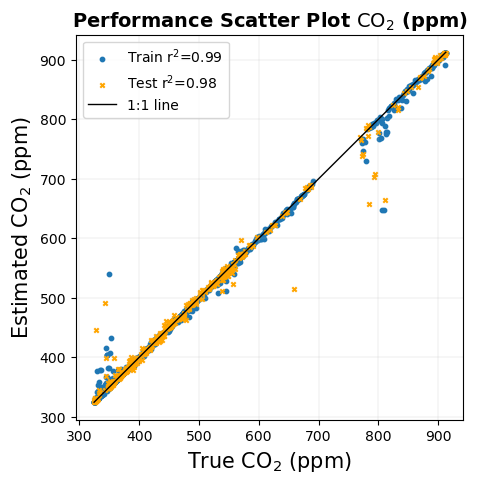

In [15]:
## Lets plot the scatter plot

import matplotlib as mpl

mpl.rcParams['mathtext.default']='regular'

plt.figure(figsize=(5,5))
plt.scatter(y_train, train_prediction_RF,s=10,c='C0',label="Train $r^2$={}".format(correlation_train))
plt.scatter(y_test, test_prediction_RF,marker='x',s=10,c='orange',label='Test $r^2$={}'.format(correlation_test))


p1 = max(max(train_prediction_RF), max(y_train))
p2 = min(min(train_prediction_RF), min(y_train))
plt.plot([p1, p2], [p1, p2], 'black',label='1:1 line',linewidth=1)
plt.xlabel('True $\mathrm{CO_2}$ (ppm)', fontsize=15)
plt.ylabel('Estimated $\mathrm{CO_2}$ (ppm)', fontsize=15)
plt.axis('equal')
plt.title("Performance Scatter Plot $\mathrm{CO_2}$ (ppm)", fontsize=14,fontweight="bold")
plt.legend()
plt.grid(axis='both',linewidth=0.15)
plt.show()

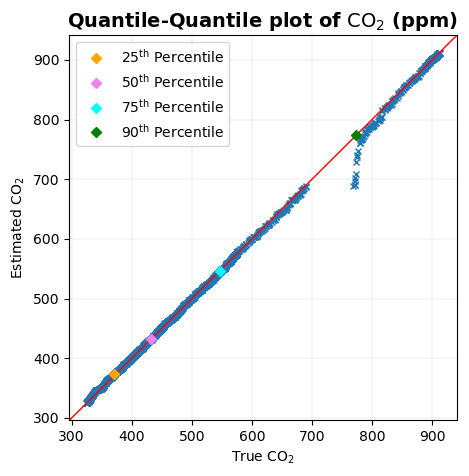

In [16]:
## Lets plot the quantile quantile 

all_preds=np.concatenate((train_prediction_RF,test_prediction_RF)) ## the list of all predictions and target values
preds=np.sort(all_preds)
tars=target.sort_values()

## This helps in customizing the graph
import statsmodels.api as sm
import scipy.stats as stats

plt.rc("figure", figsize=(5,5)) ## to make same figure size in statsmodels.api

pp_x = sm.ProbPlot(preds, fit=False)
pp_y = sm.ProbPlot(tars, fit=False)
qq = pp_x.qqplot(xlabel='True $\mathrm{CO_2}$',ylabel='Estimated $\mathrm{CO_2}$',marker='x',markersize=4,other=pp_y)

sm.qqline(qq.axes[0], line='45', fmt='r',linewidth=1)
                                 
tars_25=np.percentile(tars,25)  ## for the percentiles                                                        
tars_50=np.percentile(tars,50)
tars_75=np.percentile(tars,75)
tars_90=np.percentile(tars,90)


preds_25=np.percentile(preds,25)
preds_50=np.percentile(preds,50)
preds_75=np.percentile(preds,75)  
preds_90=np.percentile(tars,90)  ## end of percentiles

plt.plot(tars_25,preds_25,marker="D",markersize=5,color="orange",linestyle ='None',label="$\mathrm{25^{th}}$ Percentile")
plt.plot(tars_50,preds_50,marker="D",markersize=5,color="violet",linestyle ='None',label="$\mathrm{50^{th}}$ Percentile")
plt.plot(tars_75,preds_75,marker="D",markersize=5,color="Cyan",linestyle ='None',label="$\mathrm{75^{th}}$ Percentile")
plt.plot(tars_90,preds_90,marker="D",markersize=5,color="Green",linestyle ='None',label="$\mathrm{90^{th}}$ Percentile")


plt.grid(axis='both',linewidth=0.15)

plt. title('Quantile-Quantile plot of $\mathrm{CO_2}$ (ppm) ',fontsize=14,fontweight="bold")

plt.legend()
plt.show()


## Note that since the number of samples is the same, sorting the values in ascending or descending order and then...
## plotting a scatter plot will also do the same thing as the quantiles are located in same point for distribution..
## of same size.

In [17]:
## Lets now plot the Time series plot. 

## Note that using the train_test_split function shuffles the data. so first the y_train and y_test has to be....
#concatenated. Dont use the "target" variable because the predicted values-train_prediction and train_prediction are not in
## in a timestamp but in an array.

splitted_original_data=pd.concat([y_train,y_test]) ## concatenate the splitted original target variable i.e. CO_2

predicted_splited=np.concatenate((train_prediction_RF,test_prediction_RF),axis=None) #concatenate the predicted trian and...
                                                                                      ##test numpy arrays
    
splitted_df=splitted_original_data.to_frame() ##convert splitted original data CO2 from pandas series to pandas dataframe

splitted_df['predicted_splited']=predicted_splited.tolist() ## Now concatenate the CO2 dataframe and the numpy array

sorted_df=splitted_df.sort_values(by='dateTime') ## sort according to timestamp

df_reset=sorted_df.reset_index() ##reset the index and start from zero as the hh:mm:ss is not real time

df_indexed=df_reset.drop(columns="dateTime") 

df_timeseries=df_indexed.rename(columns={'CO2':'Actual $\mathrm{CO_2}$','predicted_splited':'Estimated $\mathrm{CO_2}$'})

## lets now extract rows from the timeseries so that there is discontinuity in the trials, as the red lines seen are...
## continous

timeseries_1=df_timeseries.iloc[0:709,:]
timeseries_2=df_timeseries.iloc[710:1405,:]
timeseries_3=df_timeseries.iloc[1406:2078,:]
timeseries_4=df_timeseries.iloc[2079:2316,:]

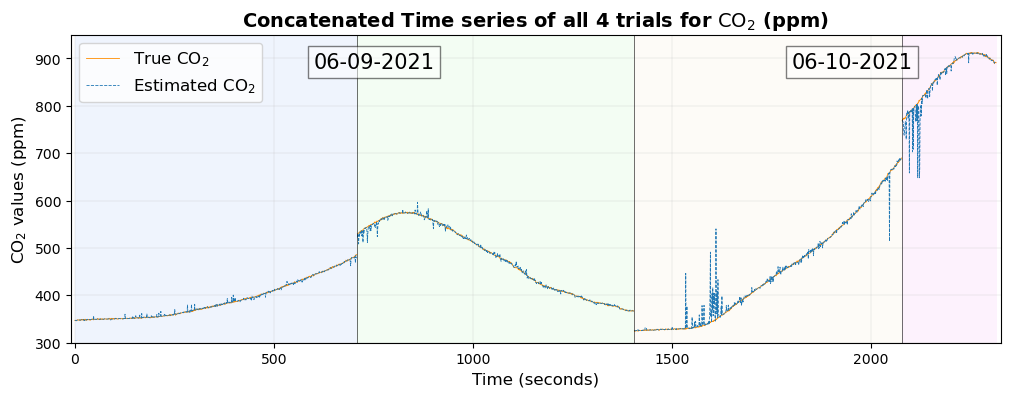

In [18]:
fig, ax = plt.subplots(figsize=(12,4))

#import matplotlib.patches as patches

ax.plot(timeseries_1['$\mathrm{CO_2}$ (ppm)'],label='True $\mathrm{CO_2}$',linewidth=0.6,color='darkorange')
ax.plot(timeseries_1['Estimated $\mathrm{CO_2}$'],label='Estimated $\mathrm{CO_2}$',linewidth=0.6,linestyle='--',color='C0')

ax.plot(timeseries_2['$\mathrm{CO_2}$ (ppm)'],linewidth=0.6,color='darkorange')
ax.plot(timeseries_2['Estimated $\mathrm{CO_2}$'],linewidth=0.6,linestyle='--',color='C0')

ax.plot(timeseries_3['$\mathrm{CO_2}$ (ppm)'],linewidth=0.6,color='darkorange')
ax.plot(timeseries_3['Estimated $\mathrm{CO_2}$'],linewidth=0.6,linestyle='--',color='C0')

ax.plot(timeseries_4['$\mathrm{CO_2}$ (ppm)'],linewidth=0.6,color='darkorange')
ax.plot(timeseries_4['Estimated $\mathrm{CO_2}$'],linewidth=0.6,linestyle='--',color='C0')


plt.text(600,880, '06-09-2021', fontsize = 15, 
         bbox = dict(facecolor = 'white', alpha = 0.5))

plt.text(1800,880, '06-10-2021', fontsize = 15, 
         bbox = dict(facecolor = 'white', alpha = 0.5))


#plt.text(250,600, 'Trial 1', fontsize = 12, 
 #        bbox = dict(facecolor = 'white', alpha = 0.5))

#plt.text(1000,600, 'Trial 2', fontsize = 12, 
 #        bbox = dict(facecolor = 'white', alpha = 0.5))

#plt.text(1600,600, 'Trial 3', fontsize = 12, 
 #        bbox = dict(facecolor = 'white', alpha = 0.5))

#plt.text(2150,600, 'Trial 4', fontsize = 12, 
 #        bbox = dict(facecolor = 'white', alpha = 0.5))

rect1 = patches.Rectangle((0, 300), 709, 650, fc="CornflowerBlue",alpha=0.1)
ax.add_patch(rect1)

rect2 = patches.Rectangle((710, 300), 695, 650, fc="lightgreen",alpha=0.1)
ax.add_patch(rect2)

rect3 = patches.Rectangle((1406, 300), 672, 650, fc="wheat",alpha=0.1)
ax.add_patch(rect3)

rect4 = patches.Rectangle((2079, 300), 237, 650, fc="violet",alpha=0.1)
ax.add_patch(rect4)

plt.xlim([-10,2327])
plt.ylim([300,950])

plt.axvline(x=709, color='k', linewidth=0.4)
plt.axvline(x=1405, color='k', linewidth=0.4)
plt.axvline(x=2078, color='k', linewidth=0.4)

plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('$\mathrm{CO_2}$ values (ppm)',fontsize=12)
plt.title('Concatenated Time series of all 4 trials for $\mathrm{CO_2}$ (ppm) ',fontsize=14,fontweight="bold")
plt.legend(fontsize=12)
plt.grid(axis='both',linewidth=0.15)
plt.show()